# 2_view_thalamus_celltypes_ccf

This notebook demonstrates how to use the custom plotting functions found in the
`thalamus_merfish_analysis\ccf_plots.py` module to view the thalamus subset of 
the Allen Brain Cell (ABC) Atlas's whole mouse brain MERFISH dataset 
(https://portal.brain-map.org/atlases-and-data/bkp/abc-atlas), which we learned 
how to load in `1_load_thalamus_data notebook.ipynb`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots

get_ipython().run_line_magic('matplotlib', 'inline') 

## Load thalamus dataset

Since we're only going to view cell types & CCF structures in this notebook, 
we can just load the cell metadata DataFrame. For details on the DataFrame output 
of `load_standard_thalamus()`, please see `1_load_thalamus_data.ipynb`.

For gene expression plots, see notebook `3_view_thalamus_gene_expression.ipynb`.

In [3]:
# load cell metadata DataFrame
obs_th = abc.load_standard_thalamus(data_structure='obs')

### Set spatial coordinates

Since we have 3 sets of spatial coordinates (`_section`, `_reconstructed`, and `_ccf`), we need to specify which coordinate space we wish to work from.

For this notebook, we will work in the `_reconstructed` coordinate space, which is a registration of each MERFISH section to a target resampled CCF section. 
For more information on the different coordinates, please see: https://alleninstitute.github.io/abc_atlas_access/notebooks/merfish_ccf_registration_tutorial.html

In [4]:
# show the three sets of coordinates
display(obs_th[['x_section', 'y_section', 'z_section',
                'x_reconstructed', 'y_reconstructed', 'z_reconstructed',
                'x_ccf', 'y_ccf', 'z_ccf']
              ].head())

x_section  y_section  z_section  x_reconstructed  \
cell_label                                                                
1019171907102970225     6.852032   6.459106        6.6         6.806941   
1018093344102600178-2   7.165970   6.029406        6.4         7.192112   
1018093344102510506-4   4.000065   6.243119        6.2         3.964947   
1018093344101270649-4   7.250921   5.934243        6.2         7.267077   
1018093344101260179-5   7.894927   5.491519        6.2         7.842704   

                       y_reconstructed  z_reconstructed     x_ccf     y_ccf  \
cell_label                                                                    
1019171907102970225           6.449028              6.6  7.204802  5.184069   
1018093344102600178-2         6.043638              6.4  7.442089  4.742288   
1018093344102510506-4         6.141358              6.2  7.521666  4.787502   
1018093344101270649-4         5.870733              6.2  7.643785  4.558091   
1018093344101260179-5         5.449421              6.2  7.708838  4.089740   

                          z_ccf  
cell_label                       
1019171907102970225    7.025149  
1018093344102600178-2  7.413300  
1018093344102510506-4  4.114865  
1018093344101270649-4  7.480014  
1018093344101260179-5  8.076068

In [5]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

### Load Allen Reference Atlas (ARA) structure images & boundaries

To overlay the ARA structures on the cell types found in the thalamus, we need to load the volume & boundary images from the ABC Atlas, which are referred to as 'CCF' from here on out.

In [6]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

In [7]:
# Precompute boundaries to use multiple times in this notebook w/o need to recompute

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

# # Alternative: skip and define as None to calculate on the fly
# ccf_boundaries = None

## View thalamus cell types + CCF parcellation

We'll use the custom plotting functions in the `thalamus_merfish_analysis/ccf_plot.py`, aka `cplots`, module to view the cell types and the aligned CCF parcellation structures

### Select sections to display

The plotting code in ccf_plots.py module displays figures per-sections, so you may wish to specify which section(s) to display.

`sections_3` stores 3 sections that are representative along AP axis of the thalamus and can be used to speed up the run time of this notebook by setting `sections=sections_3` in all the plotting functions.

If you wish to see all sections, you can: set the `sections=` parameter to `None`, not explicitly set it (`default=None`), or set it to `sections=sections_all`

In [8]:
# 3 sections that representatively span the AP axis of the thalamus
sections_3 = [6.4, 7.2, 8.0]

### Set figure saving behavior

In [9]:
save_figs = False

### View just CCF structures (no cells yet!)

In [21]:
ccf_label_col = 'parcellation_substructure'

# Display CCF structures with face colored by random palette
ccf_shape_figs = cplots.plot_ccf_overlay(obs_th.iloc[[],:], # no foreground cells; just the ccf shapes,
                                           ccf_images, 
                                           boundary_img=ccf_boundaries, 
                                           sections=sections_3, 
                                           point_hue=ccf_label_col, # set cell color (empty obs_th negates this)
                                           face_palette='glasbey', # set CCF structure face color palette
                                           edge_color='black', # set CCF structure boundary color
                                           legend='ccf',
                                           section_col=section_col,
                                           x_col=x_col, y_col=y_col)
# save as pdfs
if save_figs:
    for i, fig in enumerate(ccf_shape_figs):
        sec = int(sections_3[i]*10)
        fig.savefig(f'/results/ccf_shape_z{sec}.pdf', transparent=True, 
                    bbox_inches='tight')

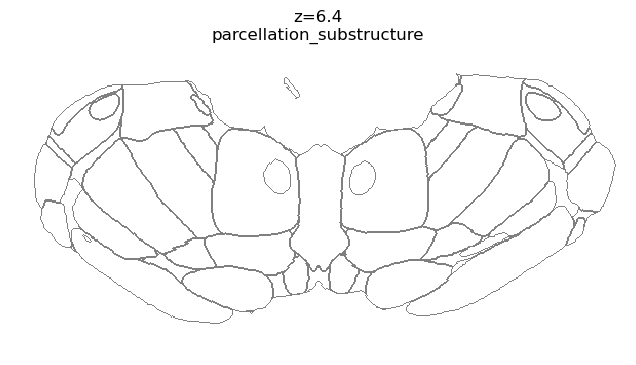

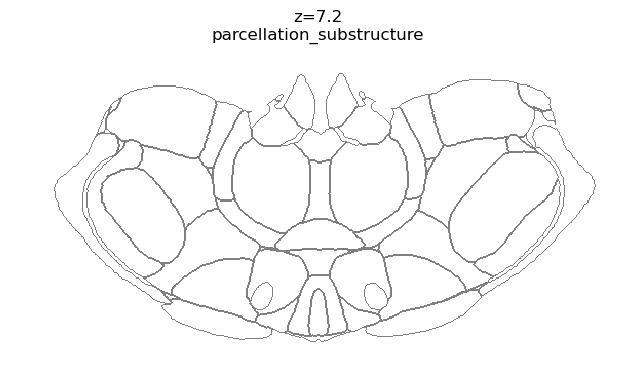

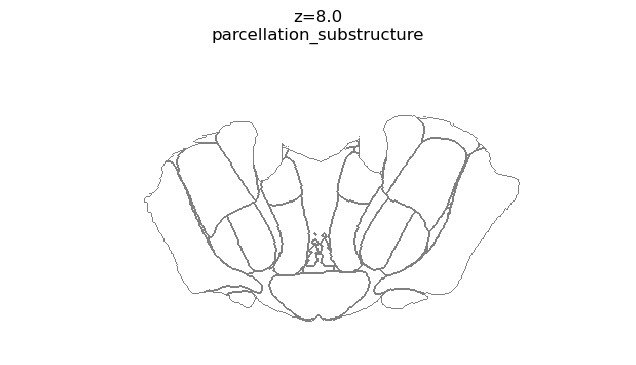

In [11]:
# diplay just the outlines of the CCF structures, no face color or legend
ccf_outline_figs = cplots.plot_ccf_overlay(obs_th.iloc[[],:], # no foreground cells; just the ccf shapes
                                           ccf_images, 
                                           boundary_img=ccf_boundaries, 
                                           sections=sections_3, 
                                           point_hue=ccf_label_col,
                                           legend=None,
                                           section_col=section_col,
                                           x_col=x_col, y_col=y_col,
                                           min_section_count=0)

### View cell types + CCF outline overlay

##### Load cell type color palettes

We provide two ways of selecting pre-set color palette to visualize cell types:
1. Use the published color palettes for the ABC Atlas taxonomy levels
2. Use a custom cluster color palette to increase contrast between spatially neighboring clusters in the thalamus

In [12]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
palette_df = pd.read_csv('/code/resources/cluster_palette_glasbey.csv')
cluster_palette = dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

#### Set plot kwargs

So we don't have to set these for each individual plot function call

In [13]:
kwargs_celltypes = dict(boundary_img=ccf_boundaries,
                        bg_cells=obs_th, # background cells are displayed in grey
                        section_col=section_col,
                        x_col=x_col, 
                        y_col=y_col,
                        s=3, # cell marker size
                        face_palette=None,
                        edge_color='grey',
                       )

#### View cells colored by neurotransmitter

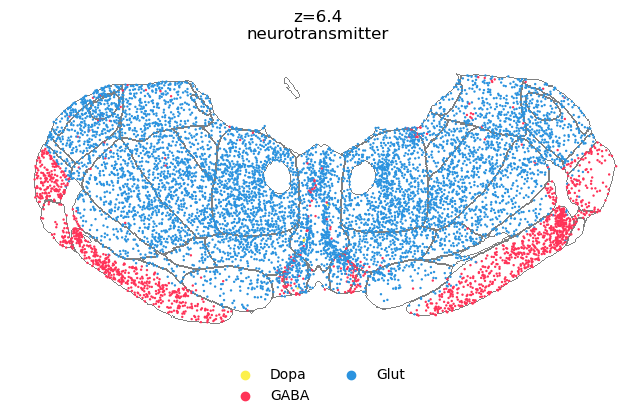

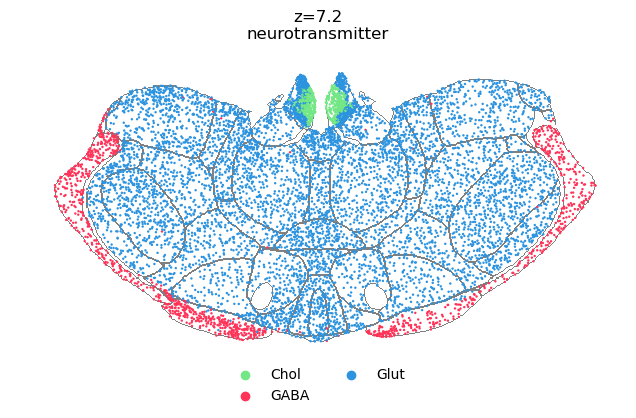

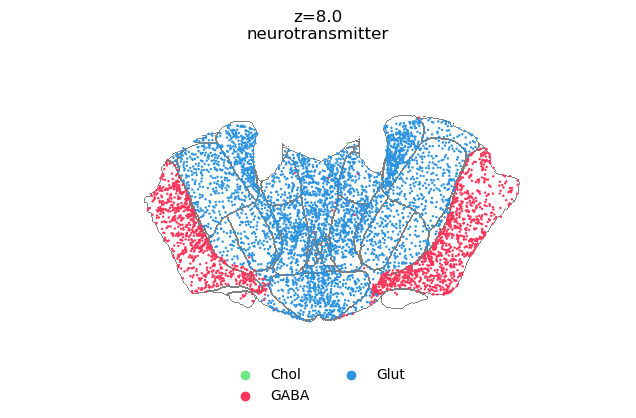

In [14]:
taxonomy_level = 'neurotransmitter'
nt_figs = cplots.plot_ccf_overlay(obs_th, ccf_images, 
                                        point_hue=taxonomy_level, 
                                        sections=sections_3,
                                        point_palette=abc_palettes[taxonomy_level],
                                        legend='cells',
                                        **kwargs_celltypes)

if save_figs: 
    for i, fig in enumerate(nt_figs):
        sec = int(sections_3[i]*10)
        fig.savefig(f'/results/ccf_{taxonomy_level}_z{sec}.pdf', transparent=True, 
                    bbox_inches='tight')

#### View cells colored by class

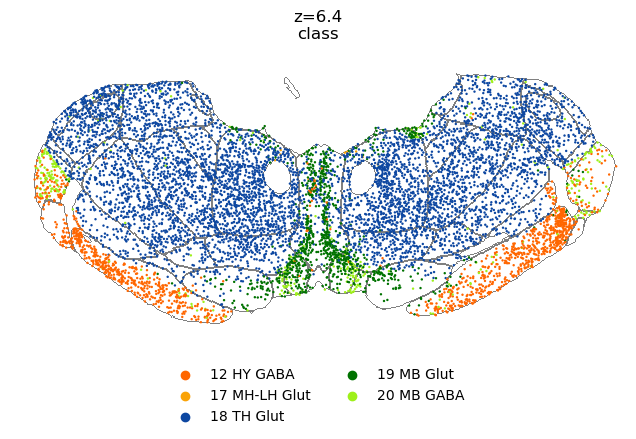

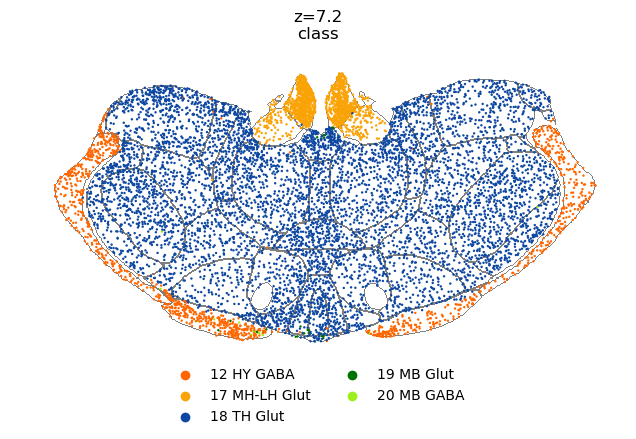

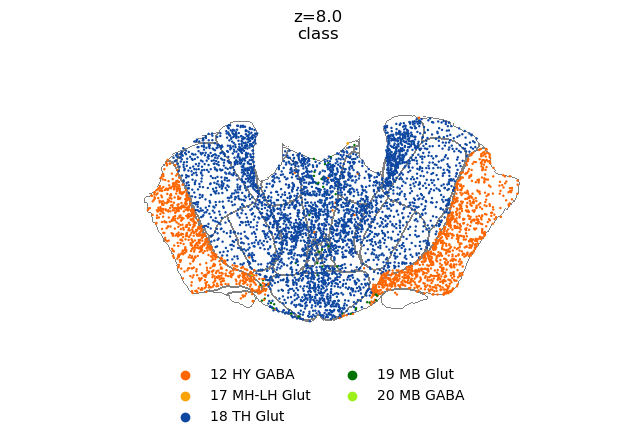

In [15]:
taxonomy_level = 'class'
class_figs = cplots.plot_ccf_overlay(obs_th, ccf_images, 
                                     point_hue=taxonomy_level, 
                                     sections=sections_3,
                                     point_palette=abc_palettes[taxonomy_level],
                                     legend='cells',
                                     **kwargs_celltypes)

if save_figs: 
    for i, fig in enumerate(class_figs):
        sec = int(sections_3[i]*10)
        fig.savefig(f'/results/ccf_{taxonomy_level}_z{sec}.pdf', transparent=True, 
                    bbox_inches='tight')

#### View cells colored by subclass

##### View all thalamus sections

By setting `sections=None`, we can display all the sections in this thalamus dataset. We don't display a legend here to save space.

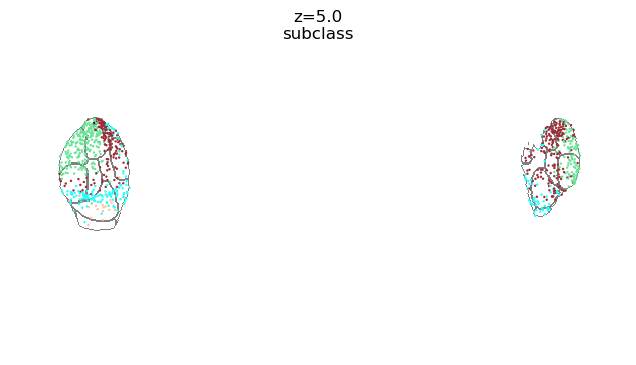

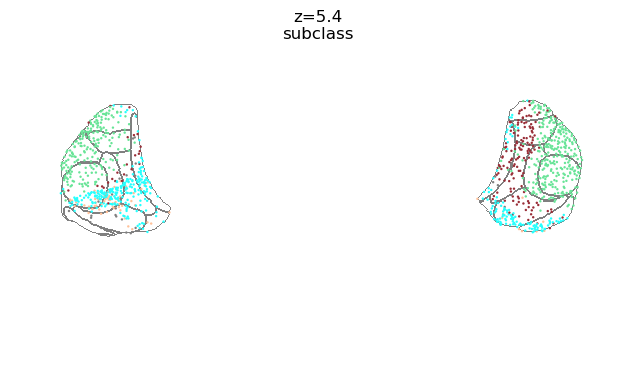

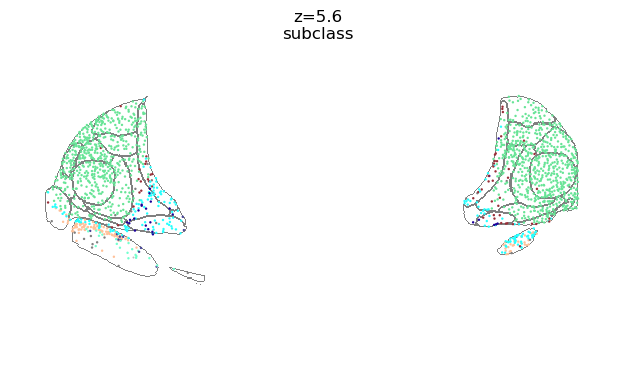

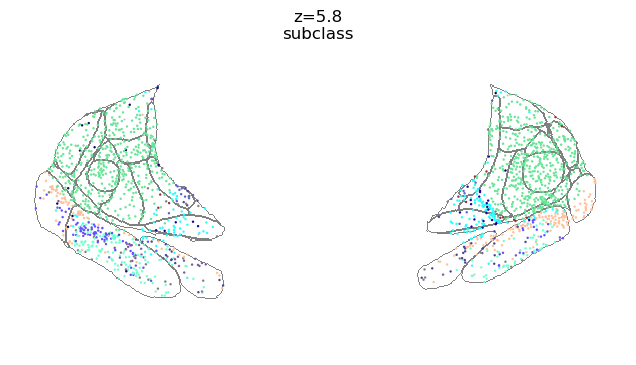

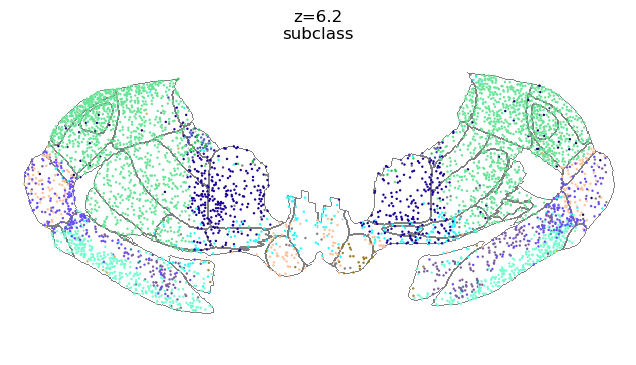

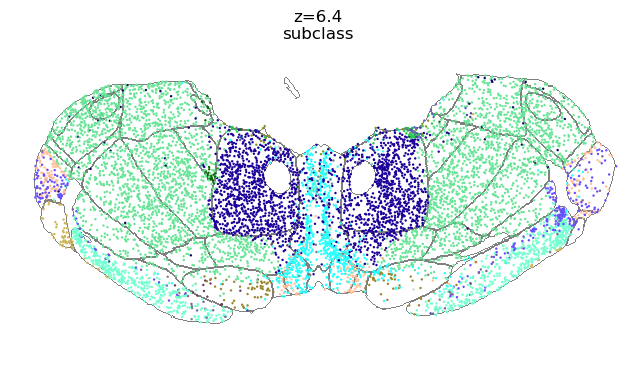

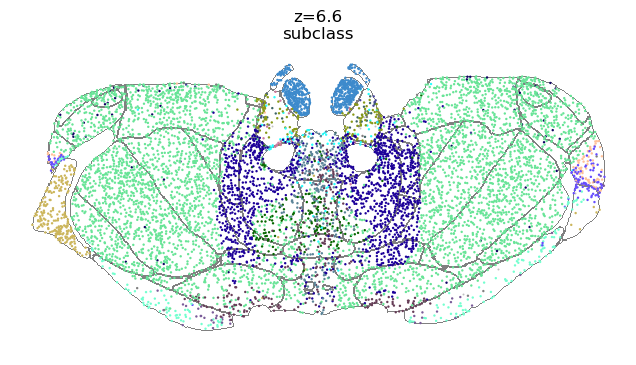

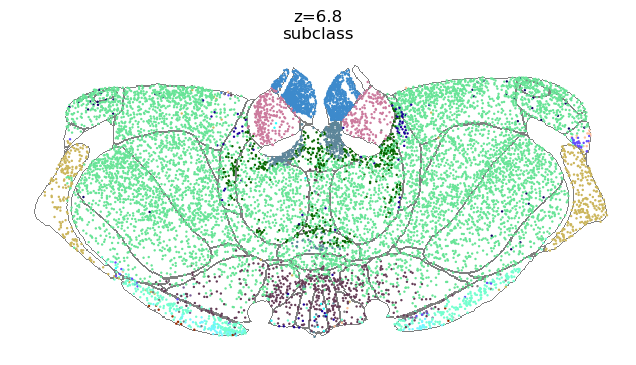

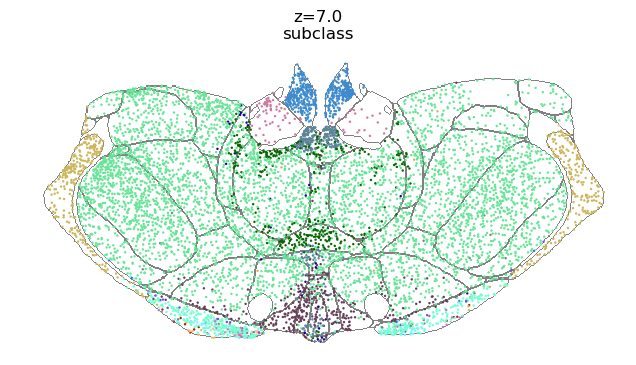

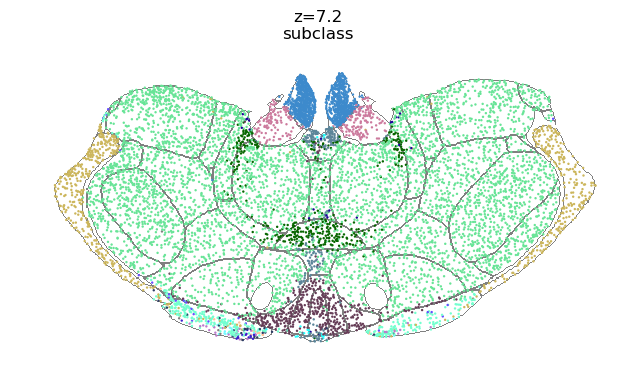

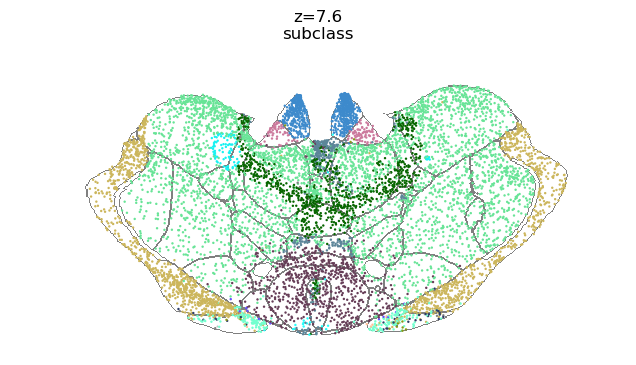

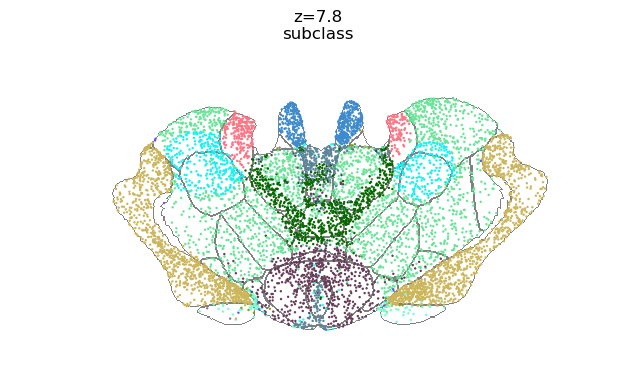

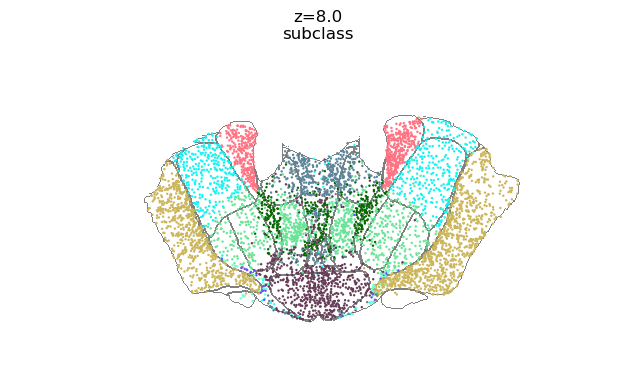

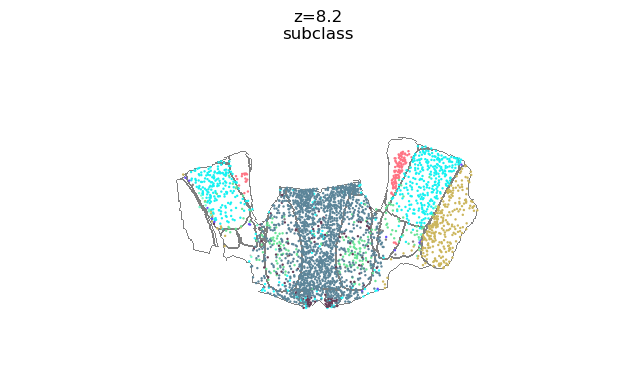

In [16]:
subclass_figs = cplots.plot_ccf_overlay(obs_th, ccf_images, 
                                        point_hue='subclass', 
                                        sections=None,
                                        point_palette=abc_palettes['subclass'],
                                        legend=None,
                                        **kwargs_celltypes)

if save_figs: 
    for i, fig in enumerate(subclass_figs):
        sec = int(sections_3[i]*10)
        fig.savefig(f'/results/ccf_subclass_z{sec}.pdf', transparent=True, 
                    bbox_inches='tight')

##### View only 3 sample sections

There are few enough subclasses that it makes sense to display a legend using `legend='cells'`.

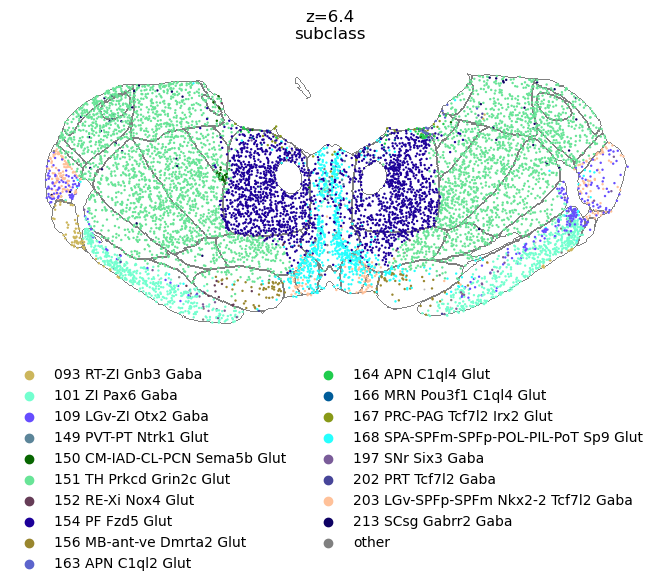

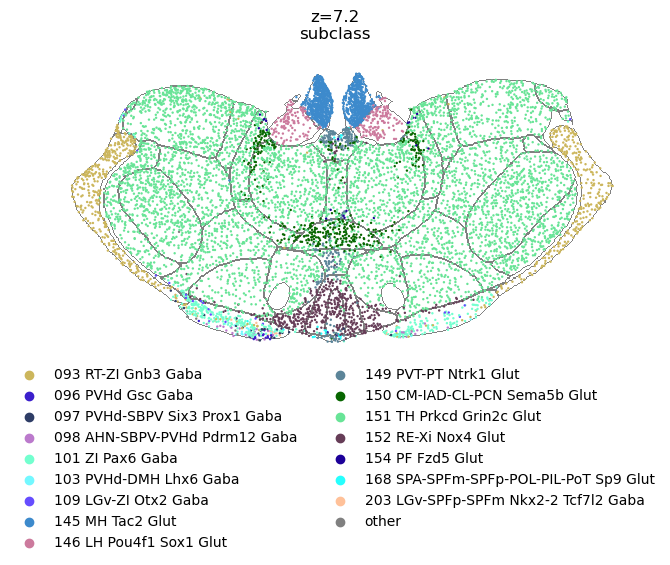

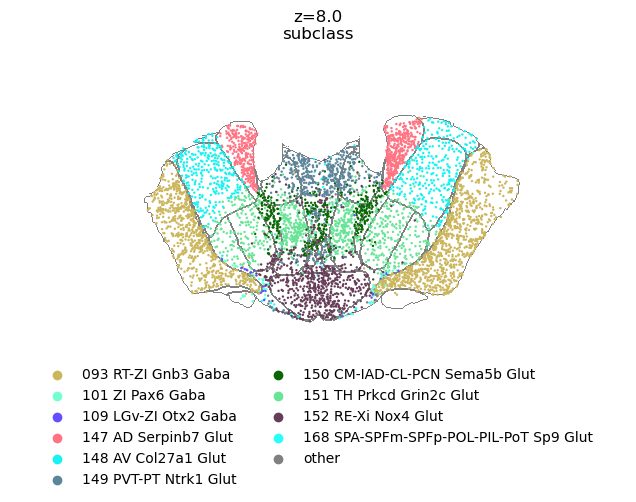

In [17]:
subclass_figs = cplots.plot_ccf_overlay(obs_th, ccf_images, 
                                        point_hue='subclass', 
                                        sections=sections_3,
                                        point_palette=abc_palettes['subclass'],
                                        legend='cells',
                                        **kwargs_celltypes)

if save_figs: 
    for i, fig in enumerate(subclass_figs):
        sec = int(sections_3[i]*10)
        fig.savefig(f'/results/ccf_subclass_z{sec}.pdf', transparent=True, 
                    bbox_inches='tight')

#### View cells colored by supertype

There are still few enough supertypes that we'll keep the legend.

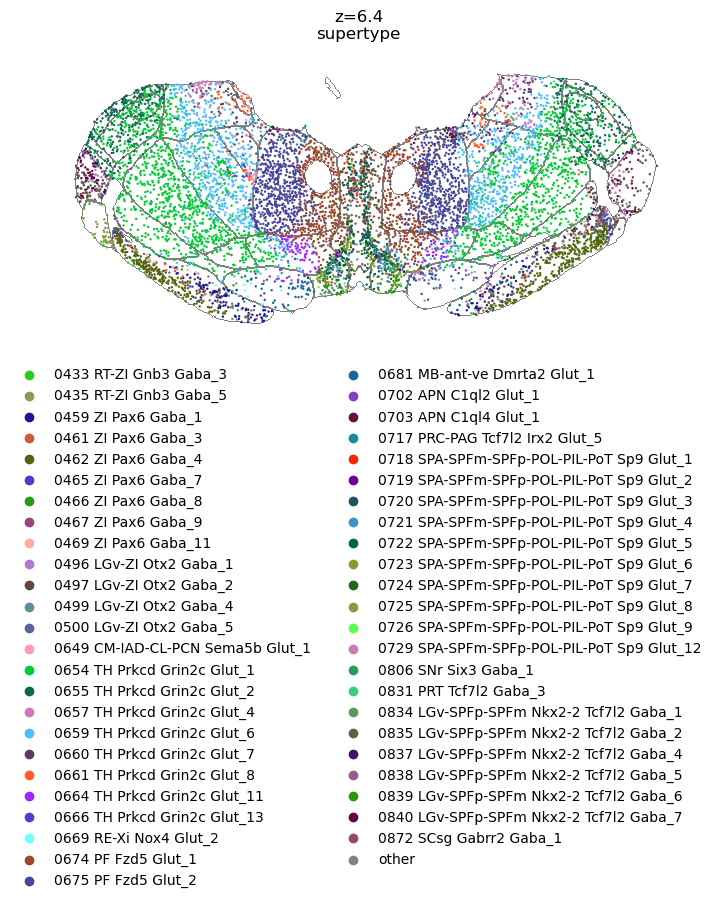

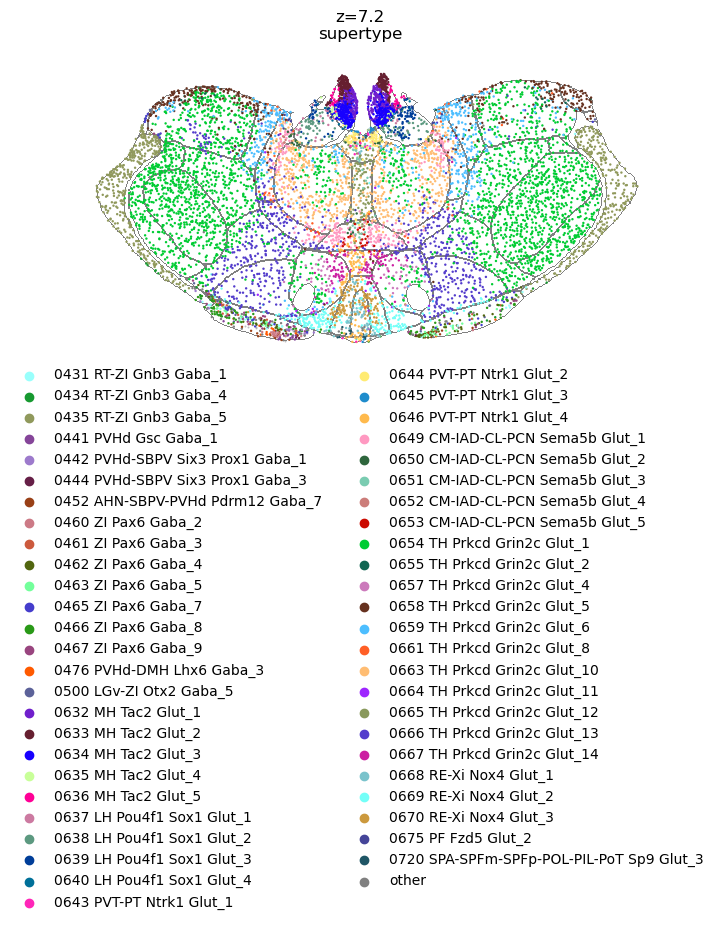

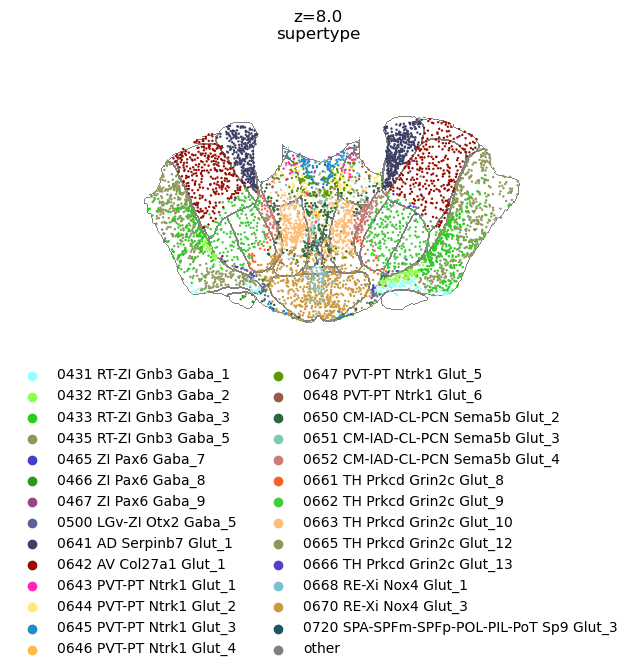

In [18]:
taxonomy_level = 'supertype'
supertype_figs = cplots.plot_ccf_overlay(obs_th, ccf_images, 
                                        point_hue=taxonomy_level, 
                                        sections=sections_3,
                                        point_palette=abc_palettes[taxonomy_level],
                                        legend='cells',
                                        **kwargs_celltypes)

if save_figs: 
    for i, fig in enumerate(supertype_figs):
        sec = int(sections_3[i]*10)
        fig.savefig(f'/results/ccf_{taxonomy_level}_z{sec}.pdf', transparent=True, 
                    bbox_inches='tight')

#### View cells colored by cluster

There are too many clusters for the legend to be readable, so we'll turn it off for this plot by setting `legend=None`.

We will also use the custom color palette loaded above to increase the contrast of neighboring clusters.

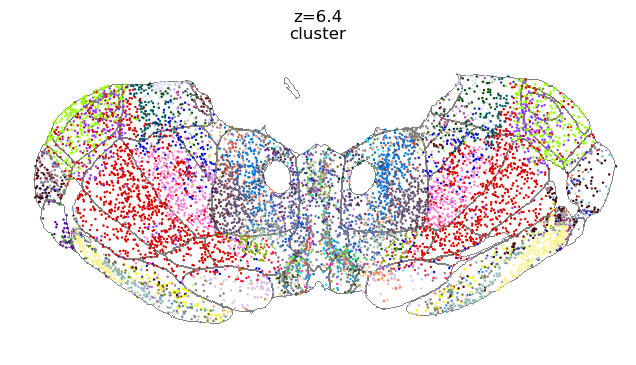

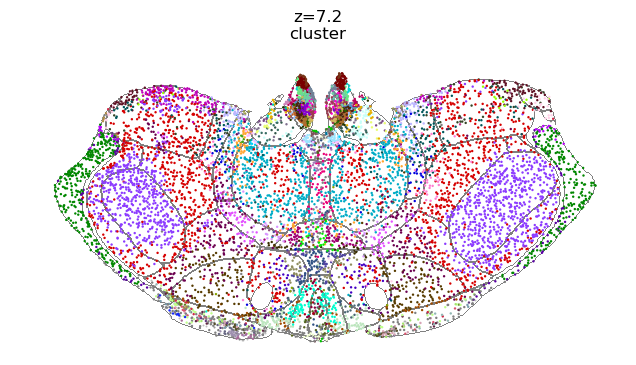

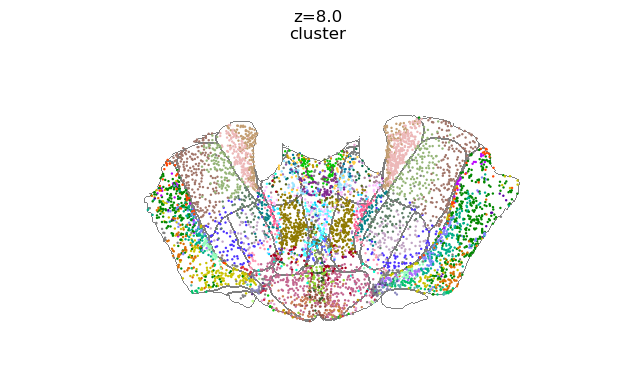

In [19]:
taxonomy_level = 'cluster'
cluster_figs = cplots.plot_ccf_overlay(obs_th, ccf_images, 
                                        point_hue=taxonomy_level, 
                                        sections=sections_3,
                                        point_palette=cluster_palette,
                                        legend=None,
                                        **kwargs_celltypes)

if save_figs: 
    for i, fig in enumerate(cluster_figs):
        sec = int(sections_3[i]*10)
        fig.savefig(f'/results/ccf_{taxonomy_level}_z{sec}.pdf', transparent=True, 
                    bbox_inches='tight')

You can compare this custom color palette to the published color palette for clusters:

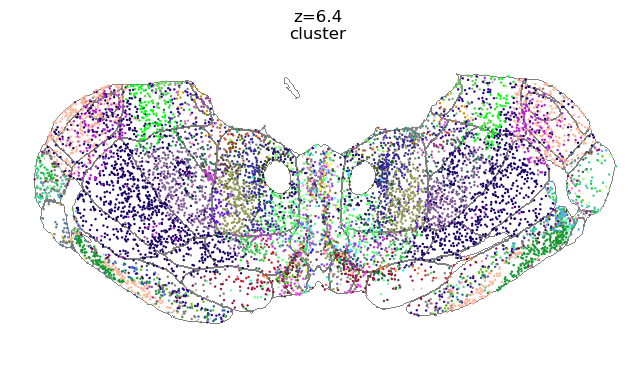

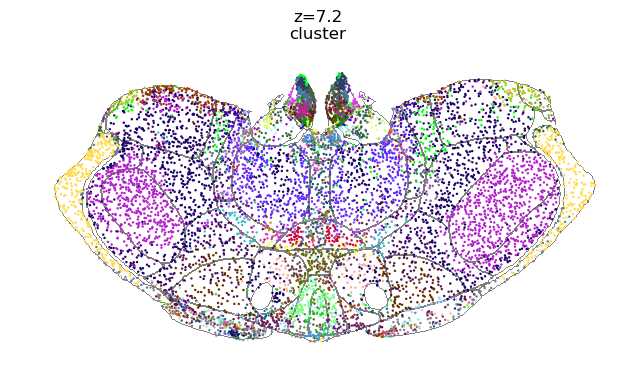

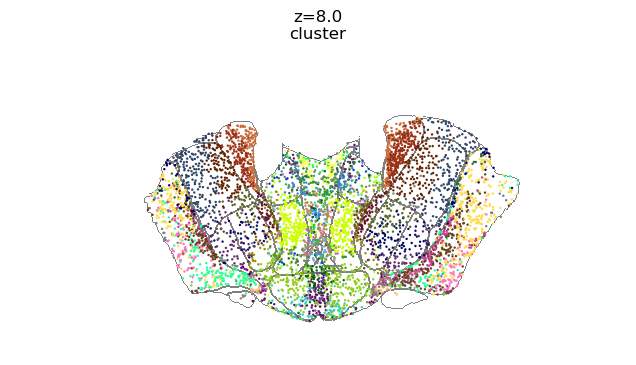

In [20]:
taxonomy_level = 'cluster'
cluster_figs = cplots.plot_ccf_overlay(obs_th, ccf_images, 
                                        point_hue=taxonomy_level, 
                                        sections=sections_3,
                                        point_palette=abc_palettes[taxonomy_level],
                                        legend=None,
                                        **kwargs_celltypes)

if save_figs: 
    for i, fig in enumerate(cluster_figs):
        sec = int(sections_3[i]*10)
        fig.savefig(f'/results/ccf_{taxonomy_level}_z{sec}.pdf', transparent=True, 
                    bbox_inches='tight')